# Coding Discussion No. 6
## Name: Sahithi Adari
### Date: 11/14/20

In [1]:
# Data Management/Investigation
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import ggplot, geom_histogram, facet_wrap, theme_minimal, theme, geom_boxplot, scale_x_discrete, labs, coord_flip, geom_point, geom_abline, theme_bw, aes

# For pre-processing data
from sklearn import preprocessing as pp
from sklearn.compose import ColumnTransformer

# For splits and CV
from sklearn.model_selection import KFold # Cross validation
from sklearn.model_selection import cross_validate # Cross validation
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

So before I could begin to create a predictor for DC housing prices, I thought it would be best to first analyze the dataset to determine what variables were the most correlated with DC housing prices.

In [2]:
#Imported the training dataset on Housing Prices in DC
train = pd.read_csv("train_data.csv")

#Saved the absolute values of the correlation matrix
correlation = train.corr().abs()

#Pivoted a level of the index labels
unstack_correlation = correlation.unstack()

#Sorted the correlations
compare = unstack_correlation.sort_values(kind="quicksort")

compare['LN_PRICE']

NUM_UNITS     0.012979
AYB           0.018329
KITCHENS      0.026424
BLDG_NUM      0.027737
USECODE       0.029356
EXTWALL       0.032202
STORIES       0.033349
INTWALL       0.051123
HEAT          0.066569
YR_RMDL       0.099024
STRUCT        0.134204
LANDAREA      0.211972
STYLE         0.220316
ROOF          0.244590
ROOMS         0.277357
SALE_NUM      0.283185
HF_BATHRM     0.286246
BEDRM         0.317807
EYB           0.346524
CNDTN         0.407624
FIREPLACES    0.456318
GBA           0.465223
BATHRM        0.480848
OBJECTID      0.505847
GRADE         0.577981
LN_PRICE      1.000000
dtype: float64

I am making the assumption here that *OBJECTID* is just the ID assigned to each house and I noticed that there are quite a few categorical variables included in the dataset: *HEAT*, *STYLE*, *STRUCT*, *GRADE*, *CNDTN*, *EXTWALL*, *ROOF*, and *INT_WALL*.

If we exlcude the above values the top 5 variables end up being: *BATHRM*, *GBA*, *FIREPLACES*, *EYB*, and *BEDRM*. For simplicity's sake I am choosing to build a predictor of price based on just these 5 values.

<AxesSubplot:>

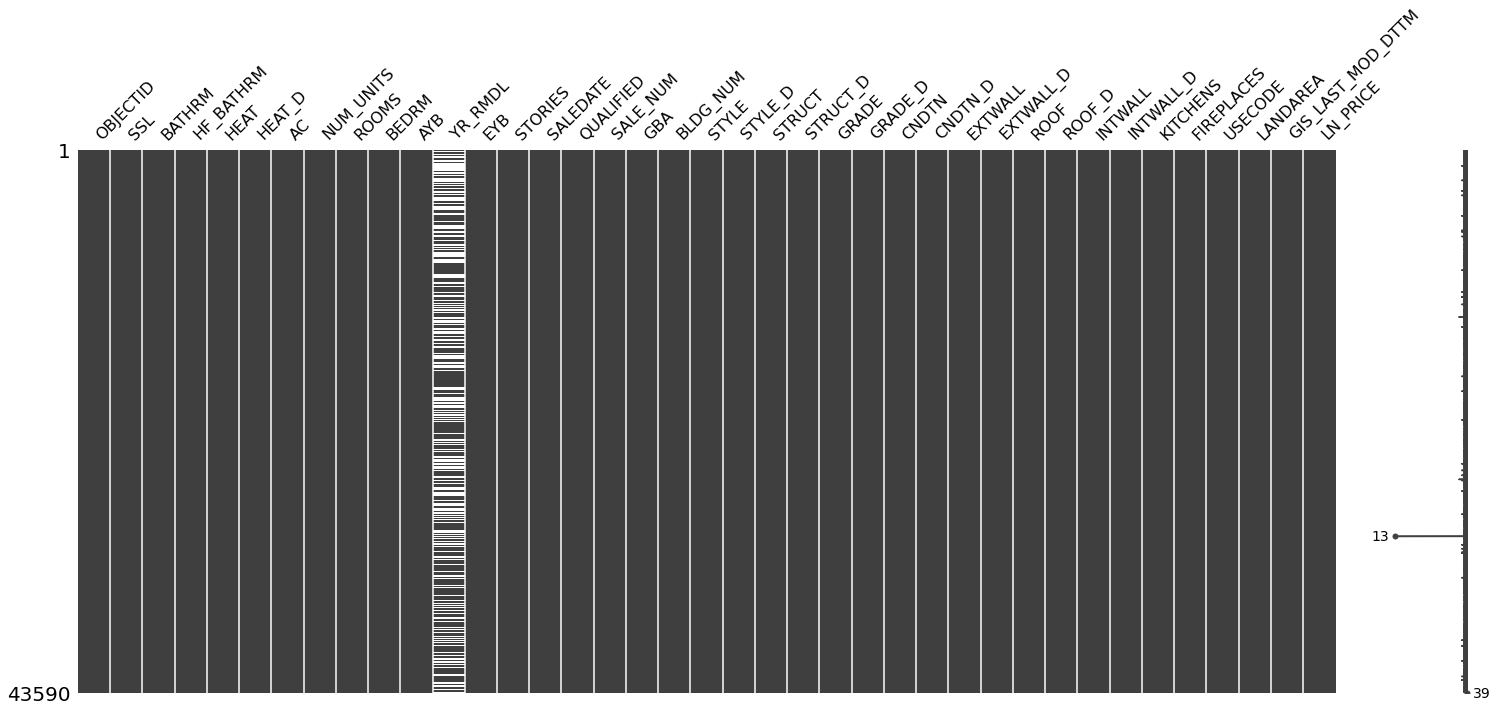

In [3]:
#Checked to see if that dataset was complete
miss.matrix(train)

In [4]:
#Dropped all observations where the outcome is missing
train = train[~train.LN_PRICE.isna()]

#Included only houses that are sold
train = train[train.LN_PRICE > 0]

In [5]:
train_y = train['LN_PRICE'] # OUTCOME: the log selling price
train_X = train[['BATHRM', 'GBA', 'FIREPLACES', 'EYB', 'BEDRM']].fillna(0) # PREDICTORS: simplified for our purposes and filled NA values with 0

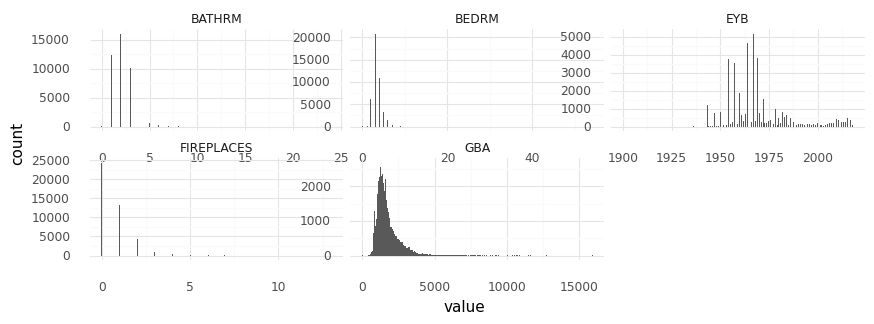

<ggplot: (317915624)>

In [6]:
#Plotted our predictors to determine if any rescaling will have to happen
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,3))
)

Given that the scale of the 5 variables are quiet different (with *EYB* even including time data) it makes sense to rescale 5 variables in order to make analysis more consistant.

In [7]:
#Scaled the 5 variables by scaling each feature to a given range
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)

In [8]:
#Converted back into data frame
train_X = pd.DataFrame(train_X, columns = col_names)

In [9]:
#Created a KFold generator in order to make valid comparions across models
fold_generator = KFold(n_splits = 5, shuffle = True, random_state = 111)

#Using means squared error as the performance metric
use_metrics = ["neg_mean_squared_error"]

In [10]:
#Linear model
lm_scores = cross_validate(LM(), train_X, train_y, cv = fold_generator, scoring = use_metrics)

In [11]:
#KNN
knn_scores = cross_validate(KNN(), train_X, train_y, cv = fold_generator, scoring = use_metrics)

In [12]:
#Decision Tree
dt_scores = cross_validate(DTree(), train_X, train_y, cv = fold_generator, scoring = use_metrics)

In [13]:
#Bagging
bag_scores = cross_validate(Bag(), train_X, train_y, cv = fold_generator, scoring = use_metrics)

In [14]:
#Random Forest
rf_scores = cross_validate(RF(), train_X, train_y, cv = fold_generator, scoring = use_metrics)

In [15]:
#Collected all the metrics as a dictionary
collect_scores = \
dict(lm = lm_scores['test_neg_mean_squared_error']*-1,
     knn = knn_scores['test_neg_mean_squared_error']*-1,
     dt = dt_scores['test_neg_mean_squared_error']*-1,
     bag = bag_scores['test_neg_mean_squared_error']*-1,
     rf = rf_scores['test_neg_mean_squared_error']*-1)

#Converted to a data frame and reshape
collect_scores = pd.DataFrame(collect_scores).melt(var_name = "Model",value_name = "MSE")

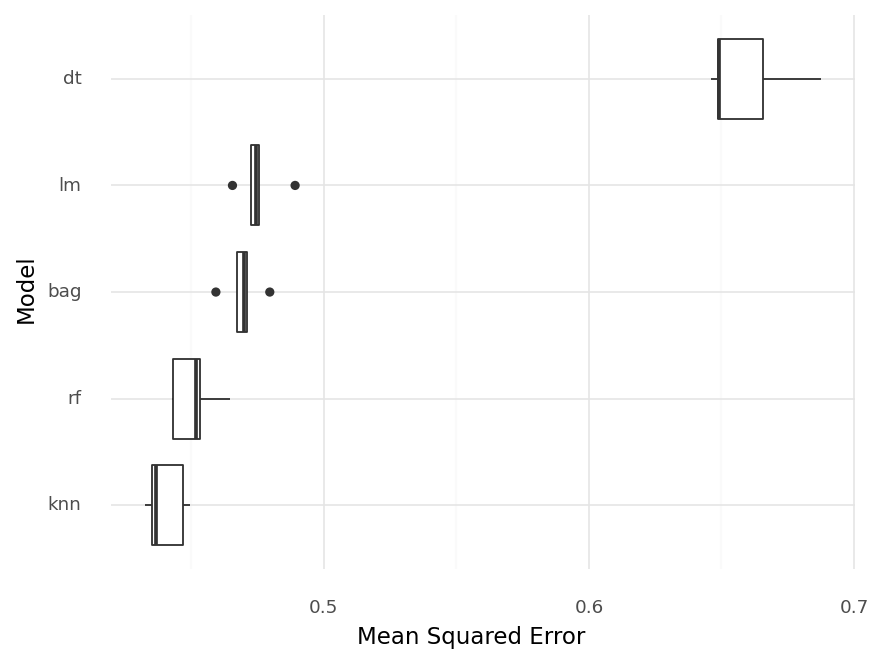

<ggplot: (318707182)>

In [16]:
#Ordered the models
order = (collect_scores.groupby('Model').mean().sort_values(by="MSE").index.tolist())

#Plot
(
    ggplot(collect_scores,
          aes(x="Model",y="MSE")) +
    geom_boxplot() +
    scale_x_discrete(limits=order) +
    labs(x="Model",y="Mean Squared Error") +
    coord_flip() +
    theme_minimal() +
    theme(dpi=150)
)

Given the the K-Nearest Neighbors seems to be the best model out of the 5, with Random Forest a really close second, I'll be focusing on fine tuning both of those 2 models.

In [17]:
#Initialized the model class for KNN
mod = KNN()

#Passed the tuning parameters into a dictionary
knn_tune_params = {'n_neighbors':[1, 10, 25, 35, 50, 75, 100, 250]}

In [18]:
#Wrapped the model method in the GridSearchCV() class
tune_knn = GridSearchCV(KNN(),knn_tune_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

#Fitted the model
tune_knn.fit(train_X, train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=KNeighborsRegressor(), n_jobs=4,
             param_grid={'n_neighbors': [1, 10, 25, 35, 50, 75, 100, 250]},
             scoring='neg_mean_squared_error')

In [19]:
#Determined the best fitting parameter
tune_knn.best_params_

{'n_neighbors': 50}

In [20]:
#Determined the best fitting score
tune_knn.best_score_

-0.3908244462657232

In [21]:
#Fine tuned max_depth, n_estimators and max_features
rf_params = {'max_depth':[1,2,3],
             'n_estimators':[100,500,1000],
              'max_features': [1,2]}
tune_rf = GridSearchCV(RF(),rf_params,
                        cv = fold_generator,
                        scoring='neg_mean_squared_error',
                        n_jobs=4)

In [22]:
#Fitted the model
tune_rf.fit(train_X, train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_depth': [1, 2, 3], 'max_features': [1, 2],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_squared_error')

In [23]:
#Determined the best fitting parameter
tune_rf.best_params_

{'max_depth': 3, 'max_features': 2, 'n_estimators': 1000}

In [24]:
#Determined the best fitting score
tune_rf.best_score_

-0.42513730504210046

In [25]:
#Created a model pipeline

#Specified the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BATHRM', 'GBA', 'FIREPLACES', 'EYB', 'BEDRM'])])

#Created the model pipeline (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])

#Specified the model and included the tuning parameters from above
search_space = [
    # Linear Model
    {'model' : [LM()]},

    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[3],
     'model__n_estimators':[1000]},
]

#Combined it all together in the grid search
search = GridSearchCV(pipe, search_space,
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

#Fitted the model to the training data
search.fit(train_X, train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'GBA',
                                                                          'FIREPLACES',
                                                                          'EYB',
                                                                          'BEDRM'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor(n_neighbors=50)],
                          'model__n_neighbors': [50]},
                   

In [26]:
#Determined the best fitting score
search.best_score_

-0.3903927992338957

In [27]:
#Determined the best fitting model
search.best_params_

{'model': KNeighborsRegressor(n_neighbors=50), 'model__n_neighbors': 50}

It appears that once we've fine-tuned for K-nearest Neighbors and Random Forest, the best model is still K-Nearest Neighbors.

In [28]:
#Imported the test dataset on Housing Prices in DC
test = pd.read_csv("test_data.csv")

In [29]:
#Dropped all observations where the outcome is missing
test = test[~test.LN_PRICE.isna()]

#Included only houses that are sold
test = test[test.LN_PRICE > 0]

In [30]:
test_y = test['LN_PRICE'] # OUTCOME: the log selling price
test_X = test[['BATHRM', 'GBA', 'FIREPLACES', 'EYB', 'BEDRM']].fillna(0) # PREDICTORS: simplified for our purposes and filled NA values with 0

In [31]:
#Scaled the 5 variables by scaling each feature to a given range
col_names_2 = list(test_X)
test_X = scaler.fit_transform(test_X)

In [32]:
#Converted back into data frame
test_X = pd.DataFrame(test_X, columns = col_names_2)

In [33]:
#Ran predict on the test data to use the best model
pred_y = search.predict(test_X)

In [34]:
#Determined the MSE of the prediction
m.mean_squared_error(test_y,pred_y)

0.4513647150946123

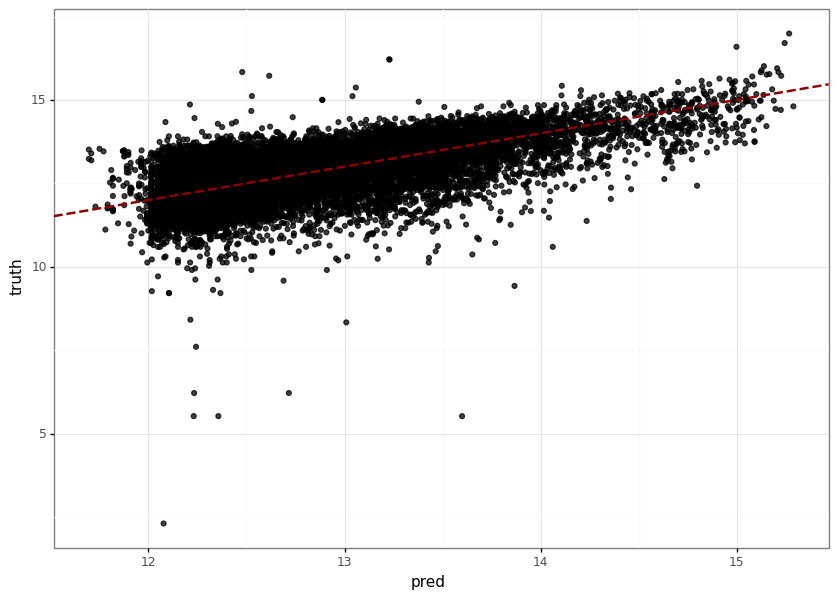

<ggplot: (318187912)>

In [35]:
#Plotted the prediction against the actual data
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

My prediction has an MSE of approximately 0.45. This a relatively good value (as we want to get as close to 0 as possible) but to really drive home the point it's worthwhile to run a secondary correlation matrix, this time between the predicted value and the test values.

In [36]:
#Correlation Matrix between the test and predicted values
np.corrcoef(test_y,pred_y)

array([[1.        , 0.63136948],
       [0.63136948, 1.        ]])

Once again, given that the Pearson correlation coefficient is 0.63, or a large strength of association, I feel fairly confident in stating that the predictor does a fairly good job on the test data.